In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import functools
import pandas as pd
import data_util_val

In [ ]:
def build_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        #logging.info('Global batch size: %d', global_batch_size)
        #logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_finetune = get_preprocess_fn()
        num_classes = 5

        def map_fn(image, label):
            image = preprocess_fn_finetune(image)
            label = tf.one_hot(label, num_classes)
            return image, label

        #logging.info('Using Astro pretrain data')
        dataset = get_data_test()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = build_input_fn(batch_size)
    return strategy.experimental_distribute_datasets_from_function(input_fn)

def get_preprocess_fn():
    #Get function that accepts an image and returns a preprocessed image
    return functools.partial(
        data_util_val.preprocess_image,
        height = 330,
        width= 330)


def get_data_test():
    #logging.info('Loading Astro test data')
    data_dir = 'imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('data_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int32)
    ds_test = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_test = ds_test.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_test

def get_number_of_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    return df.shape[0]

In [ ]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(64, strategy)
iterator = iter(ds)

In [ ]:
saved_model = tf.saved_model.load('saved_model_big_unbalanced_lr0.1_head0/26077/')

In [ ]:
representations_list = []
logits_list = []
for images, labels in iterator:
    representation = saved_model(images, trainable=False)['final_avg_pool']#['logits']
    logits = saved_model(images, trainable=False)['logits_sup']
    representation = representation.numpy()
    logits = logits.numpy()
    representations_list.append(representation)
    logits_list.append(logits)

In [ ]:
resnet = np.concatenate(np.array(representations_list, dtype=object), axis=0)
resnet = resnet.astype(np.float32)

In [ ]:
resnet.shape

In [ ]:
np.save('resnet_representations', resnet)

In [ ]:
logits = np.concatenate(np.array(logits_list, dtype=object), axis=0)
logits = logits.astype(np.float32)

In [ ]:
logits.shape

In [ ]:
np.save('logits', logits)

In [ ]:
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn

In [1]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#plt Config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
resnet = np.load('logits.npy')

In [4]:
kmeans_resnet = KMeans(n_clusters=26, init='random', algorithm='full',random_state=100000000).fit(resnet)

In [5]:
pseudolabels_resnet = kmeans_resnet.predict(resnet)
transformed_data_resnet = kmeans_resnet.transform(resnet)
centroids_resnet = kmeans_resnet.cluster_centers_

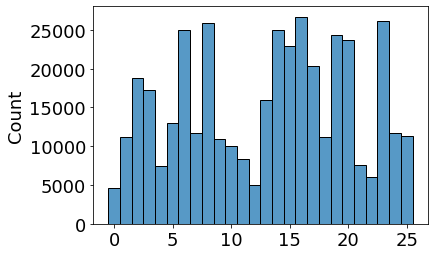

In [6]:
sns.histplot(pseudolabels_resnet, discrete=True)
plt.show()

In [7]:
centroids_resnet = kmeans_resnet.transform(centroids_resnet)

In [8]:
centroids_resnet.shape

(26, 26)

In [9]:
resnet_data = np.append(transformed_data_resnet, centroids_resnet, axis=0)

In [10]:
tsn_resnet = TSNE(n_components=2, perplexity=50, init='pca', random_state=2021)
data_resnet = tsn_resnet.fit_transform(resnet_data)
data_resnet.shape

(402110, 2)

In [11]:
data_resnet[-26:].shape

(26, 2)

In [12]:
cantroids_resnet = data_resnet[-26:]

In [13]:
data_resnett = data_resnet[:-26]

In [14]:
#colors = ['royalblue', 'tomato', 'gold', 'turquoise', 'darkorchid']
colors = ['aqua', 'azure', 'beige', 'blue', 'brown', 'chartreuse', 'coral',
          'crimson', 'darkblue', 'darkgreen', 'fuchsia', 'goldenrod', 'green', 'grey',
         'indigo', 'ivory', 'lavender', 'lightblue', 'lightgreen', 'magenta', 'orange',
         'pink', 'red', 'tan', 'wheat', 'teal']
u_labels = np.unique(pseudolabels_resnet)

In [25]:
tsne_resnet = pd.DataFrame({'X': data_resnett[:,0], 'Y': data_resnett[:,1], 'label': pseudolabels_resnet})

In [ ]:
#import matplotlib.cm as cm
#colors = ['tab:gray', 'tab:brown', 'tab:orange', 'tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'xkcd:pastel blue', 'xkcd:golden yellow', 'xkcd:bright magenta', 'xkcd:minty green']

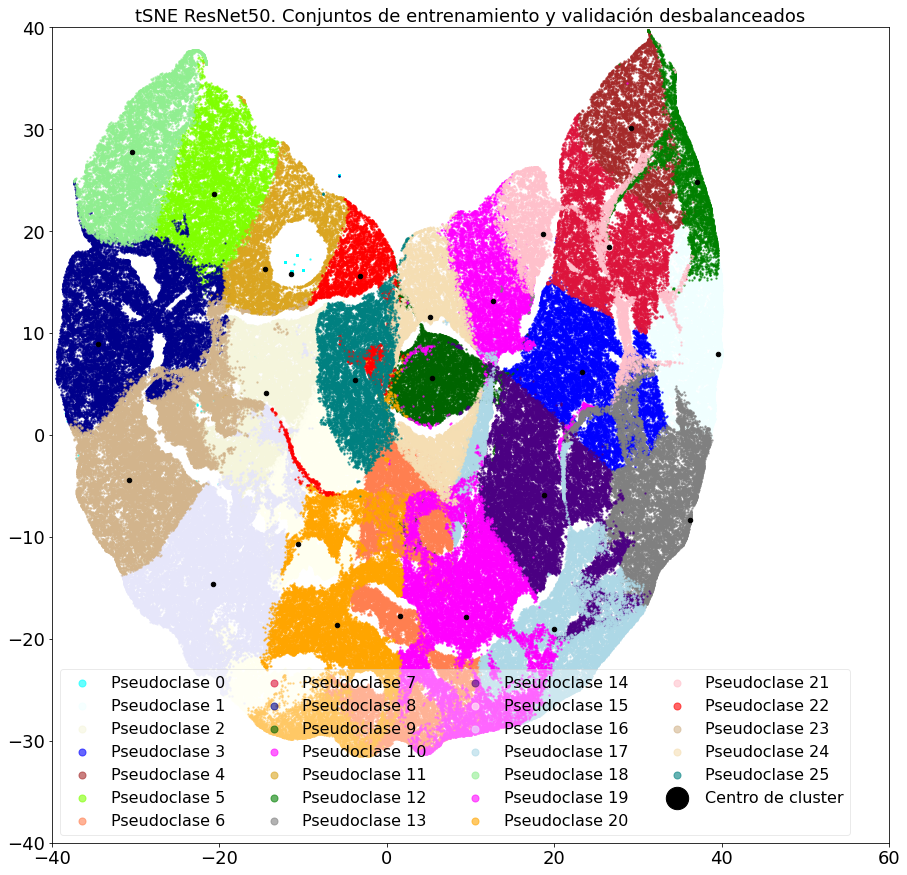

In [26]:
plt.figure(figsize=(15,15))
for i in zip(u_labels, colors):
    plt.scatter(tsne_resnet.loc[tsne_resnet.loc[:,'label'] == i[0], 'X'], tsne_resnet.loc[tsne_resnet.loc[:,'label'] == i[0], 'Y'] , label = 'Pseudoclase {}'.format(int(i[0])), alpha=0.6, c=i[1], s=2)
plt.scatter(cantroids_resnet[:,0] , cantroids_resnet[:,1] , s = 20, color = 'k', label = 'Centro de cluster')
plt.legend(markerscale=5., scatterpoints=1, ncol=4, fontsize=16, framealpha=0.4)
#plt.title('tSNE ResNet50. Modelo totalmente autosupervisado')
plt.title('tSNE ResNet50. Conjuntos de entrenamiento y validación desbalanceados')
plt.xlim(-40, 60)
plt.ylim(-40, 40)
plt.savefig("tsne_pseudolabels_fine_big_logits_26clases.pdf", format = 'pdf', dpi=100, bbox_inches = 'tight',pad_inches = 0.0)
plt.show()

In [17]:
tsne_resnet

,X,Y,label
0,-18.583899,7.962388,2
1,6.013906,15.132732,24
2,20.041895,10.887547,3
3,6.868966,14.326176,24
4,29.839552,0.528967,13
...,...,...,...
402079,17.434263,9.199927,10
402080,3.580729,-18.800858,6
402081,-0.035529,-4.220823,6
402082,-8.246282,-5.568555,15


In [18]:
names = pd.read_csv('data_train.csv')

In [19]:
names['name']

0         J121938.49+483416.0.jpg
1         J094931.61+054745.6.jpg
2         J032448.14-010547.1.jpg
3         J100641.78+623141.2.jpg
4         J140032.92+283311.4.jpg
                   ...           
402079    J145944.30+133812.3.jpg
402080    J100418.77+463812.6.jpg
402081    J120445.38+430041.0.jpg
402082    J002437.70+031919.9.jpg
402083    J155922.09+122912.6.jpg
Name: name, Length: 402084, dtype: object

In [20]:
tsne_resnet['image_name'] = names['name']

In [21]:
tsne_resnet.rename(columns={'X': 'X_tsne_projection', 'Y': 'Y_tsne_projection'}, inplace=True)

In [22]:
tsne_resnet.rename(columns={'label': 'pseudolabel_kmeans'}, inplace=True)

In [23]:
tsne_resnet.to_csv('pseudolabels_names_big_logits_26clases.csv', index=None)